## Embeddings for Weather Data

An embedding is a low-dimensional, vector representation of a (typically) high-dimensional feature which maintains the semantic meaning of the feature in a such a way that similar features are close in the embedding space.

In this notebook, we use autoencoders to create embeddings for HRRR images. We can then use the embeddings to search for "similar" weather patterns.

In [1]:
!sudo apt-get -y --quiet install libeccodes0

Reading package lists...
Building dependency tree...
Reading state information...
libeccodes0 is already the newest version (2.0.2-5).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [2]:
%pip install -q cfgrib xarray pydot

Note: you may need to restart the kernel to use updated packages.


In [1]:
import apache_beam as beam
print(beam.__version__)

2.23.0


### Reading HRRR data and converting to TensorFlow Records

HRRR data comes in a Grib2 files on Cloud Storage.

In [2]:
!gsutil ls -l gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.*.wrfsfcf00*

 105624174  2020-08-11T00:51:01Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t00z.wrfsfcf00.grib2
      7842  2020-08-11T00:50:39Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t00z.wrfsfcf00.grib2.idx
 104905515  2020-08-11T01:49:31Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t01z.wrfsfcf00.grib2
      7842  2020-08-11T01:49:04Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t01z.wrfsfcf00.grib2.idx
 101942347  2020-08-11T02:48:01Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t02z.wrfsfcf00.grib2
      7840  2020-08-11T02:47:33Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t02z.wrfsfcf00.grib2.idx
 101412287  2020-08-11T03:52:23Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t03z.wrfsfcf00.grib2
      7839  2020-08-11T03:51:52Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t03z.wrfsfcf00.grib2.idx
 101204218  2020-08-11T04:50:36Z  gs://high-resolution-rapid-ref

In [3]:
FILENAME="gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t18z.wrfsfcf06.grib2"   # derecho in the Midwest
!gsutil ls -l {FILENAME}

 128701013  2020-08-11T19:02:22Z  gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t18z.wrfsfcf06.grib2
TOTAL: 1 objects, 128701013 bytes (122.74 MiB)


In [ ]:
import xarray as xr
import tensorflow as tf
import tempfile
import cfgrib

with tempfile.TemporaryDirectory() as tmpdirname:
    TMPFILE="{}/read_grib".format(tmpdirname)
    tf.io.gfile.copy(FILENAME, TMPFILE, overwrite=True)
    ds = cfgrib.open_datasets(TMPFILE)
    print(ds)

We have to choose one of the following:
```
    filter_by_keys={'typeOfLevel': 'unknown'}
    filter_by_keys={'typeOfLevel': 'cloudTop'}
    filter_by_keys={'typeOfLevel': 'surface'}
    filter_by_keys={'typeOfLevel': 'heightAboveGround'}
    filter_by_keys={'typeOfLevel': 'isothermal'}
    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
    filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}
    filter_by_keys={'typeOfLevel': 'sigmaLayer'}
    filter_by_keys={'typeOfLevel': 'meanSea'}
    filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
    filter_by_keys={'typeOfLevel': 'sigma'}
    filter_by_keys={'typeOfLevel': 'depthBelowLand'}
    filter_by_keys={'typeOfLevel': 'isobaricLayer'}
    filter_by_keys={'typeOfLevel': 'cloudBase'}
    filter_by_keys={'typeOfLevel': 'nominalTop'}
    filter_by_keys={'typeOfLevel': 'isothermZero'}
    filter_by_keys={'typeOfLevel': 'adiabaticCondensation'}
```

[1059 1799]
2020-08-11T18:00:00.000000000
2020-08-12T00:00:00.000000000


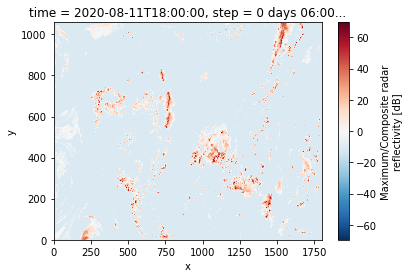

In [5]:
import xarray as xr
import tensorflow as tf
import tempfile
import cfgrib
import numpy as np

refc = 0
with tempfile.TemporaryDirectory() as tmpdirname:
    TMPFILE="{}/read_grib".format(tmpdirname)
    tf.io.gfile.copy(FILENAME, TMPFILE, overwrite=True)
    #ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface', 'stepType': 'instant'}})
    #ds.data_vars['prate'].plot()  # crain, prate
    ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'unknown', 'stepType': 'instant'}})
    #ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'atmosphere', 'stepType': 'instant'}})
    refc = ds.data_vars['refc']
    refc.plot()
    print(np.array([refc.sizes['y'], refc.sizes['x']]))
    print(refc.time.data)
    print(refc.valid_time.data)

In [6]:
print(str(refc.time.data)[:19])

2020-08-11T18:00:00


In [8]:
import numpy as np

def _array_feature(value, min_value, max_value):
    """Wrapper for inserting ndarray float features into Example proto."""
    value = np.nan_to_num(value.flatten()) # nan, -inf, +inf to numbers
    value = np.clip(value, min_value, max_value) # clip to valid
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def create_tfrecord(filename):
    with tempfile.TemporaryDirectory() as tmpdirname:
        TMPFILE="{}/read_grib".format(tmpdirname)
        tf.io.gfile.copy(filename, TMPFILE, overwrite=True)
        ds = xr.open_dataset(TMPFILE, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'unknown', 'stepType': 'instant'}})
   
        # create a TF Record with the raw data
        tfexample = tf.train.Example(
            features=tf.train.Features(
                feature={
                    'ref': _array_feature(ds.data_vars['refc'].data, min_value=0, max_value=60),
        }))
        return tfexample.SerializeToString()

s = create_tfrecord(FILENAME)
print(len(s), s[:16])

7620594 b'\n\xed\x8f\xd1\x03\n\xe8\x8f\xd1\x03\n\x03ref\x12'


In [9]:
from datetime import datetime, timedelta
def generate_filenames(startdate: str, enddate: str):
    start_dt = datetime.strptime(startdate, '%Y%m%d')
    end_dt = datetime.strptime(enddate, '%Y%m%d')
    dt = start_dt
    while dt <= end_dt:
        # gs://high-resolution-rapid-refresh/hrrr.20200811/conus/hrrr.t04z.wrfsfcf00.grib2
        f = '{}/hrrr.{:4}{:02}{:02}/conus/hrrr.t{:02}z.wrfsfcf00.grib2'.format(
                'gs://high-resolution-rapid-refresh',
                dt.year, dt.month, dt.day, dt.hour)
        dt = dt + timedelta(hours=1)
        yield f
        
def generate_shuffled_filenames(startdate: str, enddate: str):
    """
    shuffle the files so that a batch of records doesn't contain highly correlated entries
    """
    filenames = [f for f in generate_filenames(startdate, enddate)]
    np.random.shuffle(filenames)
    return filenames

print(generate_shuffled_filenames('20190915', '20190917'))

['gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t09z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t20z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t00z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t06z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t17z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t15z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t22z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t01z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t03z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190915/conus/hrrr.t21z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t02z.wrfsfcf00.grib2', 'gs://high-resolution-rapid-refresh/hrrr.20190916/conus/hrrr.t20z.wrfsfcf00

## Write a Beam pipeline

In [10]:
#%load_ext autoreload

In [ ]:
#%aimport wxsearch
#%autoreload 1
%run -m wxsearch.hrrr_to_tfrecord -- --startdate 20190915 --enddate 20190916  --outdir gs://ai-analytics-solutions-kfpdemo/wxsearch/data --project ai-analytics-solutions
# --outdir tmp

In [ ]:
!gsutil ls gs://ai-analytics-solutions-kfpdemo/wxsearch/data/tfrecord*

## Read the written TF Records

In [ ]:
# try reading what was written out
import tensorflow as tf

def parse_tfrecord(example_data):
    parsed = tf.io.parse_single_example(example_data, {
        'size': tf.io.VarLenFeature(tf.float32),
        'ref': tf.io.VarLenFeature(tf.float32),
        'time': tf.io.FixedLenFeature([], tf.string),
        'valid_time': tf.io.FixedLenFeature([], tf.string)
     })
    parsed['size'] = tf.sparse.to_dense(parsed['size'])
    parsed['ref'] = tf.reshape(tf.sparse.to_dense(parsed['ref']), (1059, 1799))/60. # 0 to 1
    return parsed

def read_dataset(pattern):
    filenames = tf.io.gfile.glob(pattern)
    ds = tf.data.TFRecordDataset(filenames, compression_type=None, buffer_size=None, num_parallel_reads=None)
    return ds.prefetch(tf.data.experimental.AUTOTUNE).map(parse_tfrecord)

ds = read_dataset('gs://ai-analytics-solutions-kfpdemo/wxsearch/data/tfrecord-00000-*')
for refc in ds.take(1):
    print(repr(refc))

## Create autoencoder in Keras

In [2]:
import tensorflow as tf
input_img = tf.keras.Input(shape=(1059, 1799, 1), name='refc_input')

x = tf.keras.layers.Cropping2D(cropping=((17, 18),(4, 3)), name='cropped')(input_img)
nlayers = 3
for layerno in range(nlayers):
    x = tf.keras.layers.Conv2D(2**(nlayers-layerno + 3), 5, activation='relu', padding='same', name='encoder_conv_{}'.format(layerno))(x)
    x = tf.keras.layers.MaxPooling2D(4, padding='same', name='encoder_pool_{}'.format(layerno))(x)
x = tf.keras.layers.Lambda(lambda x: x, name='refc_embedding')(x)
for layerno in range(nlayers):
    x = tf.keras.layers.Conv2D(2**(layerno + 4), 5, activation='relu', padding='same', name='decoder_conv_{}'.format(layerno))(x)
    x = tf.keras.layers.UpSampling2D(4, name='decoder_upsamp_{}'.format(layerno))(x)
x = tf.keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same', name='before_padding')(x)
decoded = tf.keras.layers.ZeroPadding2D(padding=((17,18),(4,3)), name='refc_reconstructed')(x)

autoencoder = tf.keras.Model(input_img, decoded, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
refc_input (InputLayer)      [(None, 1059, 1799, 1)]   0         
_________________________________________________________________
cropped (Cropping2D)         (None, 1024, 1792, 1)     0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 1024, 1792, 64)    1664      
_________________________________________________________________
encoder_pool_0 (MaxPooling2D (None, 256, 448, 64)      0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 256, 448, 32)      51232     
_________________________________________________________________
encoder_pool_1 (MaxPooling2D (None, 64, 112, 32)       0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 64, 112, 16)       

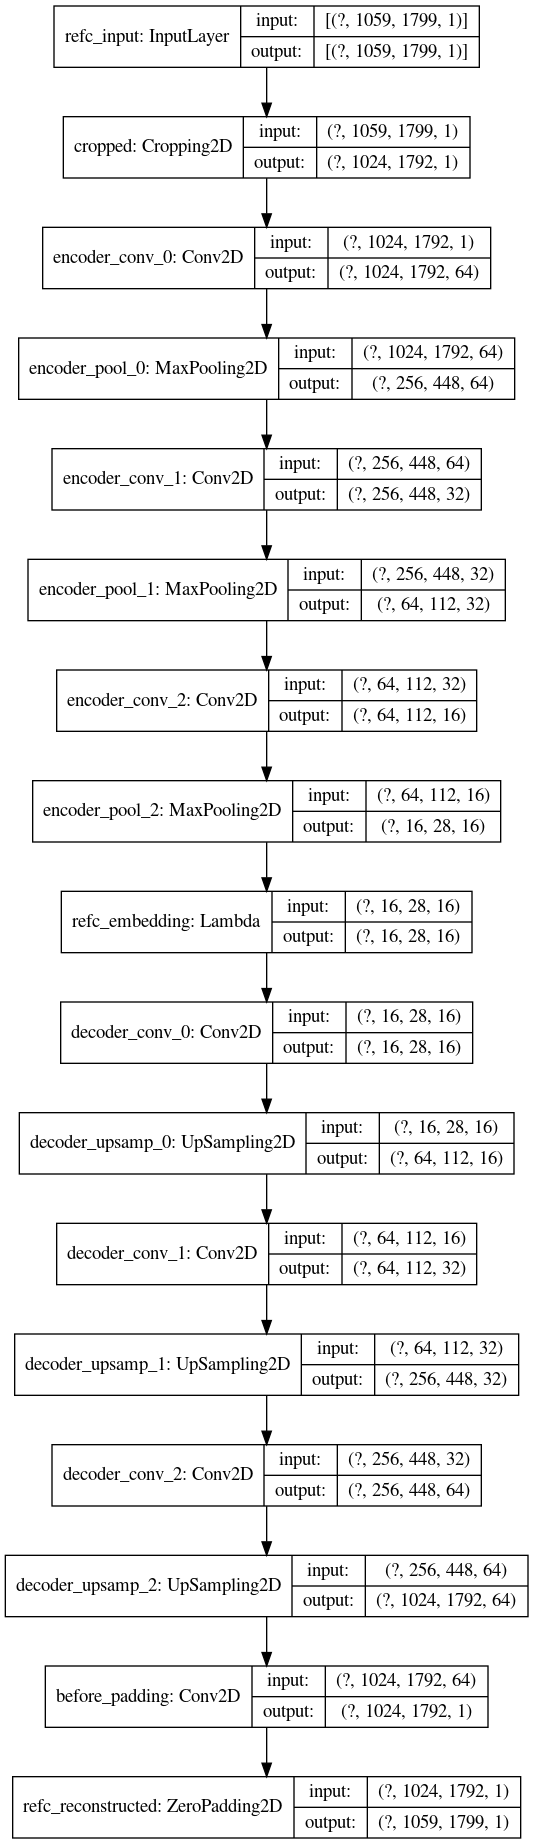

In [4]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True, to_file='autoencoder.png')

## Train the autoencoder

In [ ]:
def input_and_label(rec):
    return rec['ref'], rec['ref']

ds = read_dataset('gs://ai-analytics-solutions-kfpdemo/wxsearch/data/tfrecord-*').map(input_and_label).batch(2).repeat()
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoints')
history = autoencoder.fit(ds, steps_per_epoch=1, epochs=3, shuffle=True, callbacks=[checkpoint])
print(history)

In [ ]:
autoencoder.save('tmp/savedmodel')

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss']);

In [ ]:
#%aimport wxsearch
#%autoreload 1
%run -m wxsearch.train_autoencoder -- --input gs://ai-analytics-solutions-kfpdemo/wxsearch/data/tfrecord-*  --outdir gs://ai-analytics-solutions-kfpdemo/wxsearch/trained --project ai-analytics-solutions

## Run at scale

In [ ]:
%run -m wxsearch.hrrr_to_tfrecord -- --startdate 20190101 --enddate 20200101  --outdir gs://ai-analytics-solutions-kfpdemo/wxsearch/data/2019 --project ai-analytics-solutions

<img src="dataflow_2019.png" />

In [9]:
%%writefile train.yaml
trainingInput:
  scaleTier: CUSTOM
  masterType: n1-highmem-2
  masterConfig:
    acceleratorConfig:
      count: 2
      type: NVIDIA_TESLA_K80
  runtimeVersion: '2.2'
  pythonVersion: '3.7'
  scheduling:
    maxWaitTime: 3600s
    maxRunningTime: 7200s

Overwriting train.yaml


In [1]:
%%bash

PROJECT=$(gcloud config get-value project)
echo ${PROJECT}
BUCKET="ai-analytics-solutions-kfpdemo"
PACKAGE_PATH="${PWD}/wxsearch"
now=$(date +"%Y%m%d_%H%M%S")
JOB_NAME="wxsearch_$now"
MODULE_NAME="wxsearch.train_autoencoder"
JOB_DIR="gs://${BUCKET}/wxsearch/train/jobdir"
REGION="us-central1"

# 9000 images in dataset
gcloud ai-platform jobs submit training $JOB_NAME \
        --package-path $PACKAGE_PATH \
        --module-name $MODULE_NAME \
        --job-dir $JOB_DIR \
        --region $REGION \
        --config train.yaml \
        -- \
        --input gs://${BUCKET}/wxsearch/data/2019/tfrecord-* \
        --outdir gs://${BUCKET}/wxsearch/trained \
        --project ${PROJECT} \
        --batch_size 4 --num_steps 1000 --num_checkpoints 10

ai-analytics-solutions
jobId: wxsearch_20201007_192101
state: QUEUED


Job [wxsearch_20201007_192101] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe wxsearch_20201007_192101

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs wxsearch_20201007_192101


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License